# EmoNet: Advanced Emotion Classification Using NLP Techniques
## Problem Statement:

Create an advanced emotion classification model leveraging state-of-the-art Natural Language Processing (NLP) techniques to accurately identify and categorize emotions expressed in textual data. The objective is to develop a model capable of effectively predicting the emotional sentiment associated with each document in a given dataset. This entails training the model on a diverse corpus of documents annotated with corresponding emotion labels and optimizing its performance to achieve high accuracy and robustness in classifying emotions across various contexts. The resulting model should exhibit superior capabilities in understanding and interpreting nuanced emotional nuances, enabling its application in a wide range of real-world scenarios such as sentiment analysis, customer feedback analysis, and mood detection in conversational interfaces.

## Aim:

- Develop a high-performing emotion classification model using NLP techniques to accurately categorize emotions expressed in textual data.

## Dataset Attributes

- Text Data: Each entry contains a piece of text representing a statement or expression of emotion. These textual documents vary in length and content, reflecting the diverse range of emotional experiences.

- Emotion Label: The emotion label indicates the predominant emotion conveyed in the corresponding text data. Emotions such as sorrow, rage, happiness, amaze, care, and scare are represented in the dataset.

# Load Dataset

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
data = pd.read_csv('train.csv')
data.head(5)

,Text,Emotion
0,i didnt feel humiliated,sorrow
1,i can go from feeling so hopeless to so damned...,sorrow
2,im grabbing a minute to post i feel greedy wrong,rage
3,i am ever feeling nostalgic about the fireplac...,care
4,i am feeling grouchy,rage


# Data Analysis

- Describe the dataset, including the number of entries (documents) present.
- Determine the frequency of each emotion category in the dataset.
- Utilize visualizations such as bar charts or pie charts to display the distribution of emotions in the dataset.
- Interpret the statistical plots to extract meaningful insights that can inform the development of the EmoNet model.

**Describe the dataset, including the number of entries (documents) present.**

In [ ]:
num_entries = len(data)
print("Number of entries (documents) present:", num_entries)

Number of entries (documents) present: 15000


In [ ]:
data.describe().T

,count,unique,top,freq
Text,15000,14973,i was intensely conscious of how much cash i h...,2
Emotion,15000,6,happiness,5034


In [ ]:
# Check the data types of columns
print("\nData types of columns:")
print(data.dtypes)


Data types of columns:
Text       object
Emotion    object
dtype: object


In [ ]:
# Check for any missing values
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
Text       0
Emotion    0
dtype: int64


In [ ]:
# Check for duplicate values
duplicates = data[data.duplicated()]
print("Total duplicate rows:", duplicates.shape[0])
data.drop_duplicates()

Total duplicate rows: 1


,Text,Emotion
0,i didnt feel humiliated,sorrow
1,i can go from feeling so hopeless to so damned...,sorrow
2,im grabbing a minute to post i feel greedy wrong,rage
3,i am ever feeling nostalgic about the fireplac...,care
4,i am feeling grouchy,rage
...,...,...
14995,i feel so sympathetic empathetic towards them,care
14996,i just had a very brief time in the beanbag an...,sorrow
14997,i feel strong and good overall,happiness
14998,i feel like this was such a rude comment and i...,rage


**Determine the frequency of each emotion category in the dataset.**

In [ ]:
emotion_frequency = data['Emotion'].value_counts()

print("Frequency of each emotion category:")
print(emotion_frequency)

Frequency of each emotion category:
Emotion
happiness    5034
sorrow       4368
rage         2016
scare        1817
care         1223
amaze         542
Name: count, dtype: int64


**Utilize visualizations such as bar charts or pie charts to display the distribution of emotions in the dataset.**

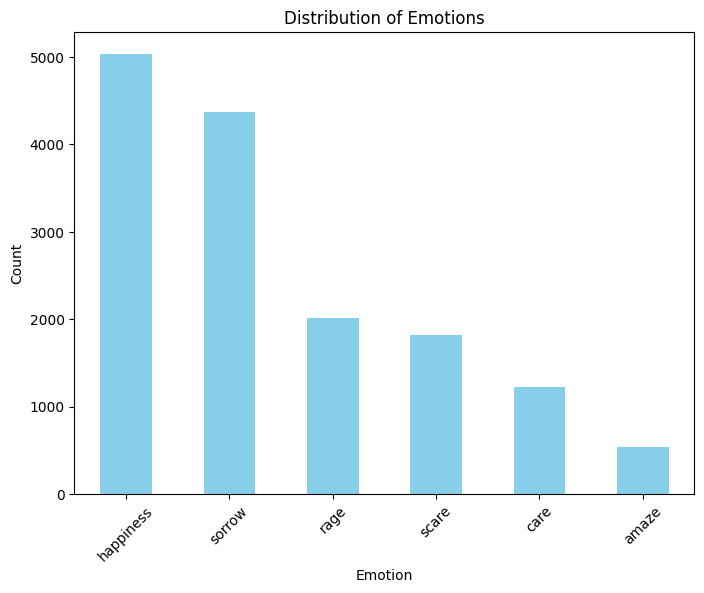

In [ ]:
# Plotting the distribution of emotions using a bar chart
plt.figure(figsize=(8, 6))
emotion_frequency.plot(kind='bar', color='skyblue')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- The emotion with the highest count is "happiness", indicating a significant portion of the dataset expressing happiness or joyful emotions.

- The emotion with the lowest count is "amaze", implying a minimal presence of awe, amazement, or fascination in the dataset.

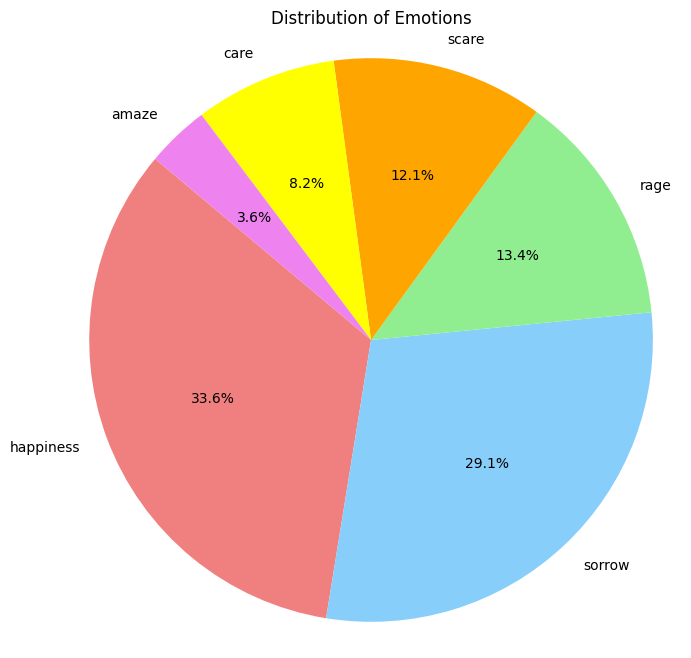

In [ ]:
# Plotting the distribution of emotions using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_frequency, labels=emotion_frequency.index, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightskyblue', 'lightgreen', 'orange', 'yellow', 'violet'])
plt.title('Distribution of Emotions')
plt.axis('equal')
plt.show()

- The second-largest slice (29.1%) represents "sorrow", representing the significant portion of sadness or melancholic feelings.

- "Rage" occupies 13.4% of the pie chart, indicating a considerable representation of anger or intense emotions.

- "Scare" and "care" account for 12.1% and 8.2% of the distribution, respectively, suggesting a moderate presence of fear and caring/nurturing sentiments.

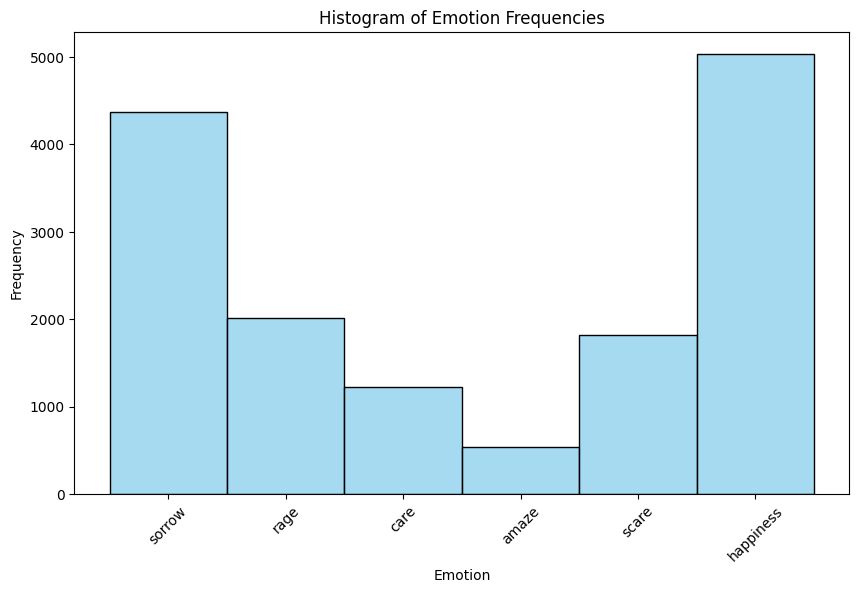

In [ ]:
# Plotting a histogram of emotion frequencies
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Emotion', color='skyblue', discrete=True)
plt.title('Histogram of Emotion Frequencies')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

**Interpret the statistical plots to extract meaningful insights that can inform the development of the EmoNet model.**

In [ ]:
# Calculate the imbalance ratio
imbalance_ratio = emotion_frequency.min() / emotion_frequency.max()
print("Imbalance ratio:", imbalance_ratio)

Imbalance ratio: 0.10766785856177989


- The imbalance ratio, calculated as the minimum frequency divided by the maximum frequency, is 0.107. This low value confirms the presence of a substantial class imbalance, where some emotions have significantly fewer instances compared to others.

- The histogram visualizes the frequency distribution of different emotions in the dataset. The emotions "happiness" and "sorrow" have the highest frequencies, suggesting they are the predominant emotions in the dataset.

- On the other hand, emotions like "scare" and "amaze" have relatively lower frequencies, indicating they are underrepresented in the data.

# Data pre-processing & Feature Engineering

- Preprocess the text data to remove noise and irrelevant information, such as punctuation, special characters, and stop words.
- Perform tokenization to break down the text data into individual words or tokens.
- Using the provided dataset, create a word cloud to visualize the frequency of words in the text. Describe the process you followed to create the word cloud.
- Experiment with different text representation techniques, such as frequency vector, TF-IDF (Term Frequency-Inverse Document Frequency)to transform the text data into numerical features that can be used by machine learning models.

**Preprocess the text data to remove noise and irrelevant information, such as punctuation, special characters, and stop words.**

**Perform tokenization to break down the text data into individual words or tokens.**

In [ ]:
# Define function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters and numbers using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)

    return preprocessed_text

# Apply preprocessing to the 'Text' column
data['Preprocessed_Text'] = data['Text'].apply(preprocess_text)

# Display the first few rows of the preprocessed data
print(data[['Text', 'Preprocessed_Text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                Text  \
0                            i didnt feel humiliated   
1  i can go from feeling so hopeless to so damned...   
2   im grabbing a minute to post i feel greedy wrong   
3  i am ever feeling nostalgic about the fireplac...   
4                               i am feeling grouchy   

                                   Preprocessed_Text  
0                              didnt feel humiliated  
1  go feeling hopeless damned hopeful around some...  
2          im grabbing minute post feel greedy wrong  
3  ever feeling nostalgic fireplace know still pr...  
4                                    feeling grouchy  


**Using the provided dataset, create a word cloud to visualize the frequency of words in the text. Describe the process you followed to create the word cloud.**

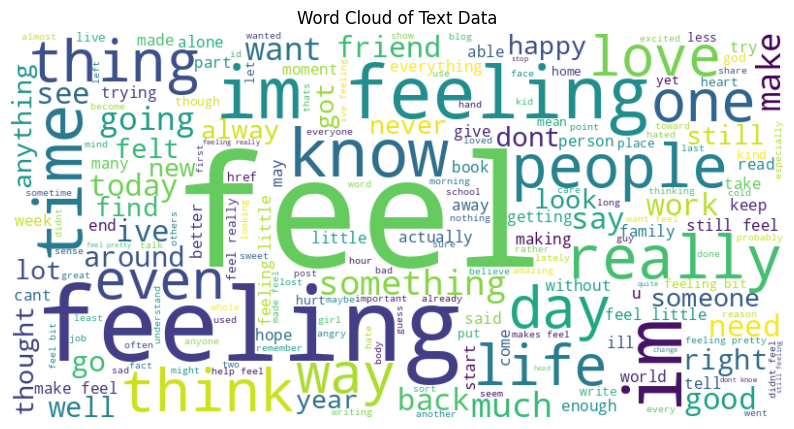

In [ ]:
# Combine all preprocessed text into a single string
all_text = ' '.join(data['Preprocessed_Text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

To create the word cloud, I followed these steps:

1. **Text Preprocessing:** Defined a function preprocess_text to preprocess the text data. This function converts text to lowercase, removes special characters and numbers using regex, tokenizes the text, removes stopwords, and joins the tokens back into text. The preprocessing helps in cleaning the text data and removing noise.

2. **Apply Preprocessing:** Applied the preprocess_text function to the 'Text' column of the dataset to obtain preprocessed text.

3. **Combine Preprocessed Text:** Combined all preprocessed text into a single string. This string contains all the words from the preprocessed text data.

4. **Generate Word Cloud:** Utilized the WordCloud library to generate the word cloud. The WordCloud class creates a visualization of the frequency of words in the text.

5. **Plot Word Cloud:** Plotted the generated word cloud using matplotlib. The imshow function displays the word cloud.

**Experiment with different text representation techniques, such as frequency vector, TF-IDF (Term Frequency-Inverse Document Frequency) to transform the text data into numerical features that can be used by machine learning models.**

In [ ]:
# Text representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_vector = tfidf_vectorizer.fit_transform(data['Preprocessed_Text'])

# Display the data head
print("Head of the data after TF-IDF:")
print(data.head())

# Display the TF-IDF feature matrix
print("\nTF-IDF Feature Matrix:")
print(tfidf_vector.toarray())

Head of the data after TF-IDF:
                                                Text Emotion  \
0                            i didnt feel humiliated  sorrow   
1  i can go from feeling so hopeless to so damned...  sorrow   
2   im grabbing a minute to post i feel greedy wrong    rage   
3  i am ever feeling nostalgic about the fireplac...    care   
4                               i am feeling grouchy    rage   

                                   Preprocessed_Text  
0                              didnt feel humiliated  
1  go feeling hopeless damned hopeful around some...  
2          im grabbing minute post feel greedy wrong  
3  ever feeling nostalgic fireplace know still pr...  
4                                    feeling grouchy  

TF-IDF Feature Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


**Extra credit if you perform word embeddings (e.g., Word2Vec, GloVe) to transform the text data into numerical features that can be used by machine learning models.**

In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(data['Preprocessed_Text'], min_count=1, vector_size=100, window=5)

# Function to generate word embeddings using Word2Vec
def get_word2vec_embeddings(tokens, model):
    embeddings = []
    for token in tokens:
        if token in model.wv:
            embeddings.append(model.wv[token])
    if len(embeddings) == 0:
        return np.zeros(100)  # Return zero vector if no embeddings found
    else:
        return np.mean(embeddings, axis=0)  # Return the mean of word embeddings

# Apply word embeddings to the preprocessed text data
data['Word2Vec_Embeddings'] = data['Preprocessed_Text'].apply(lambda x: get_word2vec_embeddings(x, word2vec_model))

# Display the first few rows of the data with embeddings
print(data[['Text', 'Word2Vec_Embeddings']].head())

                                                Text  \
0                            i didnt feel humiliated   
1  i can go from feeling so hopeless to so damned...   
2   im grabbing a minute to post i feel greedy wrong   
3  i am ever feeling nostalgic about the fireplac...   
4                               i am feeling grouchy   

                                 Word2Vec_Embeddings  
0  [0.14769118, -0.022184977, 0.19262743, -0.0133...  
1  [0.1929077, -0.048424836, 0.21278311, 0.033337...  
2  [0.20043883, -0.025376746, 0.17783777, 0.01899...  
3  [0.18537083, -0.044933293, 0.17450725, 0.01333...  
4  [0.21977624, -0.023311798, 0.19076438, -0.0072...  


# LDA

- Apply Latent Dirichlet Allocation (LDA) to uncover themes in the text data. Set the number of topics to 8 and extract 10 keywords per topic.
- Describe your approach, including any preprocessing steps. Present the identified topics with their keywords.
- Discuss the importance of topic modeling in revealing hidden themes and extracting insights from the dataset.

**Apply Latent Dirichlet Allocation (LDA) to uncover themes in the text data. Set the number of topics to 8 and extract 10 keywords per topic.**

In [ ]:
# Convert preprocessed text to list of lists
preprocessed_text_list = data['Preprocessed_Text'].apply(lambda x: x.split()).tolist()

# Create the LDA model
lda_model = LatentDirichletAllocation(n_components=8, max_iter=10, learning_method='online', random_state=42)

# Fit the LDA model
lda_model.fit(tfidf_vector)

# Function to print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Print the top words for each topic
print("\nTopics and Top Words:")
print_top_words(lda_model, tfidf_vectorizer.get_feature_names_out(), 10)


Topics and Top Words:

Topic #0:
amazing angry pain feel generous free thats selfish super melancholy

Topic #1:
feel feeling like im really know people one would today

Topic #2:
feel anxious slightly feeling discouraged devastated supporting particularly uncertain lethargic

Topic #3:
feel feeling im like alone sad better hated accepted every

Topic #4:
feel feeling like im happy http last lot href sure

Topic #5:
horrible wonderful matter sympathetic child feel lovely honored insulted money

Topic #6:
feel god feeling comfortable see insecure miss sense making awful

Topic #7:
agitated cold strange ashamed extremely inspired defeated feel listless numb


**Describe your approach, including any preprocessing steps. Present the identified topics with their keywords.**

To apply Latent Dirichlet Allocation (LDA) and uncover themes in the text data, I followed these steps:

**1. Preprocessing:**

Converted the preprocessed text to a list of lists where each sublist contains the preprocessed words of each document.
The preprocessing steps include converting text to lowercase, removing special characters and numbers, tokenizing the text, and removing stopwords.

**2. LDA Model Creation:**

Created an LDA model with 8 topics and set the maximum number of iterations to 10.
Used the TF-IDF vectorizer to convert the text data into a matrix of TF-IDF features.

**3. Fitting the LDA Model:**

Fitted the LDA model to the TF-IDF vectorized data.

**4. Identifying Topics and Top Keywords:**

Defined a function print_top_words to print the top keywords for each topic.
Printed the top 10 keywords for each of the 8 topics identified by the LDA model.

The identified topics and keywords are -

Topic #0:
amazing angry pain feel generous free thats selfish super melancholy

Topic #1:
feel feeling like im really know people one would today

Topic #2:
feel anxious slightly feeling discouraged devastated supporting particularly uncertain lethargic

Topic #3:
feel feeling im like alone sad better hated accepted every

Topic #4:
feel feeling like im happy http last lot href sure

Topic #5:
horrible wonderful matter sympathetic child feel lovely honored insulted money

Topic #6:
feel god feeling comfortable see insecure miss sense making awful

Topic #7:
agitated cold strange ashamed extremely inspired defeated feel listless numb

**Discuss the importance of topic modeling in revealing hidden themes and extracting insights from the dataset.**

Topic modeling, particularly through Latent Dirichlet Allocation (LDA), unveils latent themes within text data, providing valuable insights from the dataset. Here are the topics and their potential meanings that I identified:

**Topic #0: Mixed Emotions**

Meaning: This topic covers a mix of emotions, from anger and pain to generosity and melancholy. It suggests that the text discusses a range of contrasting emotions.

**Topic #1: Personal Reflection**

Meaning: Words like "feel," "feeling," and "like" indicate personal reflection, while "people" and "know" suggest social interaction. The topic may revolve around personal feelings and relationships.

**Topic #2: Anxiety and Uncertainty**

Meaning: Words such as "anxious," "discouraged," and "uncertain" suggest feelings of anxiety and insecurity. This topic may explore themes of stress and uncertainty.

**Topic #3: Emotional Isolation**

Meaning: The words "alone," "sad," and "hated" suggest feelings of isolation and rejection, while "accepted" conveys a sense of belonging. This topic may explore themes of loneliness, rejection, and self-acceptance.

**Topic #4: Contentment**

Meaning: Words like "happy" and "sure" convey contentment and confidence. This topic may discuss positive experiences and satisfaction.

**Topic #5: Mixed Feelings**

Meaning: This topic reflects a range of emotions, from "horrible" to "wonderful," suggesting a variety of experiences and feelings. It may discuss life's ups and downs, including challenges and moments of gratitude.

**Topic #6: Spiritual Reflection**

Meaning: Words like "god," "insecure," and "awful" hint at spiritual reflection and seeking comfort. The topic may delve into questions of faith and purpose.

**Topic #7: Emotional States**

Meaning: This topic covers a mix of emotional states, from agitation and shame to inspiration and listlessness. It may explore mental health and motivation.


# Modeling

- Train at least three different  models.
- Choose the best feature engineering method and perform grid search & cross-validation to tune hyperparameters for three different models, optimizing their performance for emotion classification and Also, for each model, plot the ROC-AUC curve?

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['Preprocessed_Text'], data['Emotion'], test_size=0.2, random_state=42)

**Train at least three different models**

In [ ]:
# Define models with hyperparameters
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, C=1.0, penalty='l2')),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
]

# Define feature engineering methods with hyperparameters
vectorizers = [
    ('TF-IDF', TfidfVectorizer(max_features=None)),
    ('Word2Vec', Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4))
]

**Choose the best feature engineering method and perform grid search & cross-validation to tune hyperparameters for three different models, optimizing their performance for emotion classification and Also, for each model, plot the ROC-AUC curve**

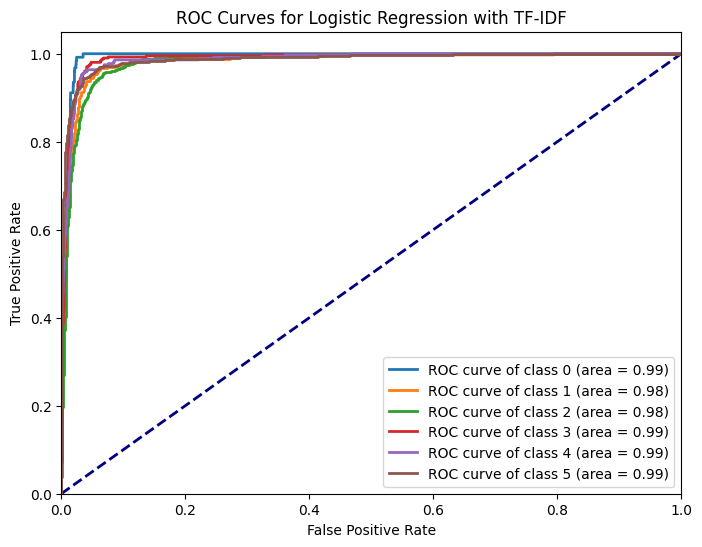

Model: Logistic Regression, Feature Engineering: TF-IDF
Cross-validation Accuracy: 0.8363
Test Accuracy: 0.8620
ROC AUC Score: 0.9868



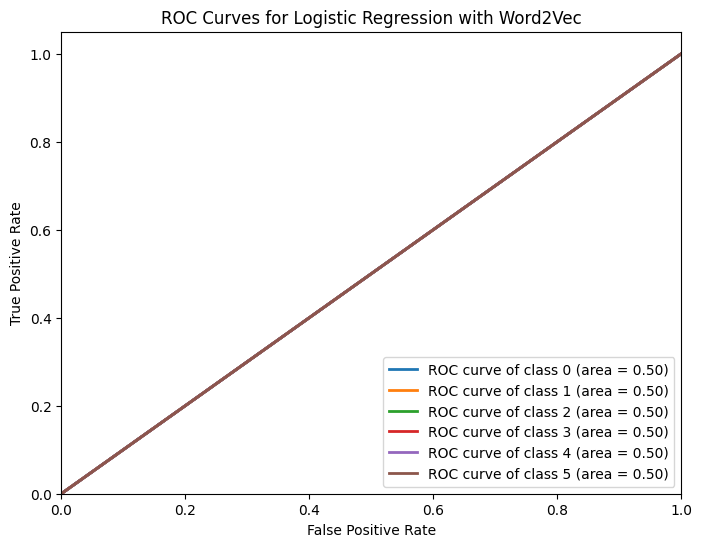

Model: Logistic Regression, Feature Engineering: Word2Vec
Cross-validation Accuracy: 0.3377
Test Accuracy: 0.3270
ROC AUC Score: 0.5000



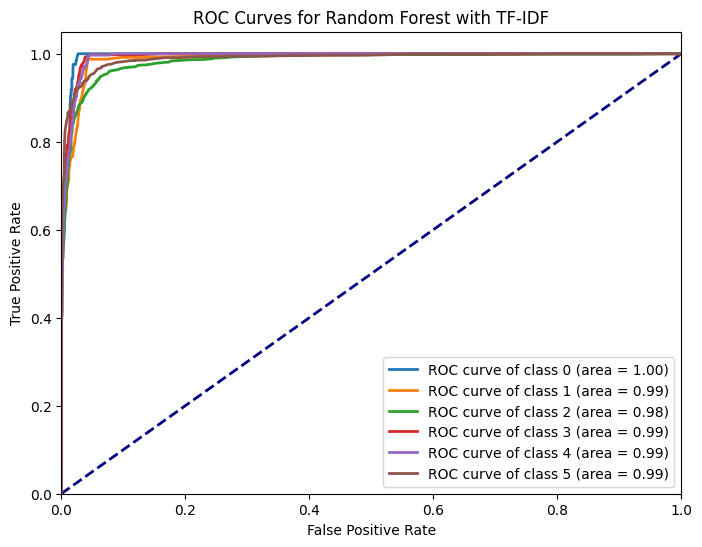

Model: Random Forest, Feature Engineering: TF-IDF
Cross-validation Accuracy: 0.8703
Test Accuracy: 0.8897
ROC AUC Score: 0.9906



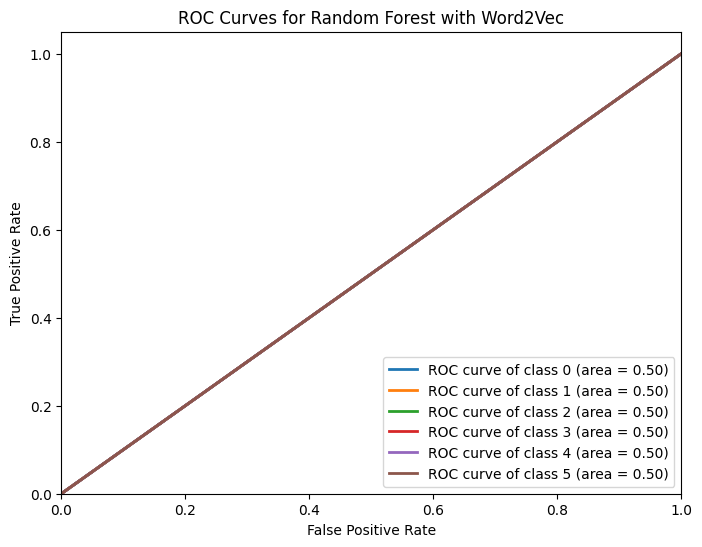

Model: Random Forest, Feature Engineering: Word2Vec
Cross-validation Accuracy: 0.3377
Test Accuracy: 0.3270
ROC AUC Score: 0.5000



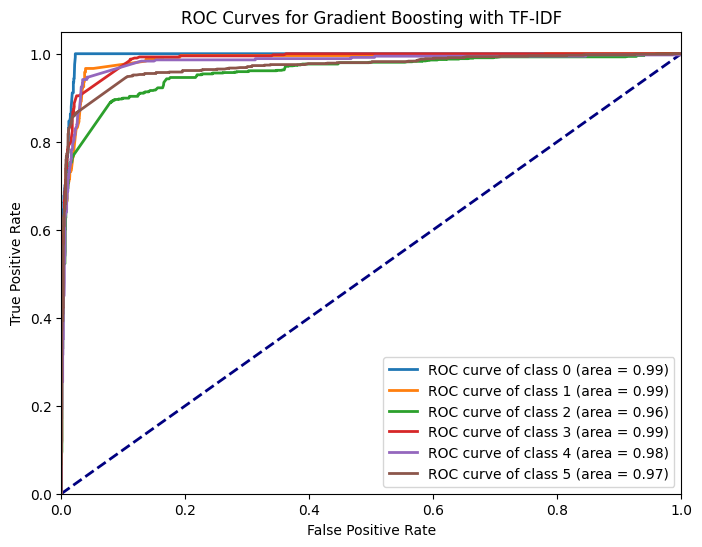

Model: Gradient Boosting, Feature Engineering: TF-IDF
Cross-validation Accuracy: 0.8319
Test Accuracy: 0.8343
ROC AUC Score: 0.9791



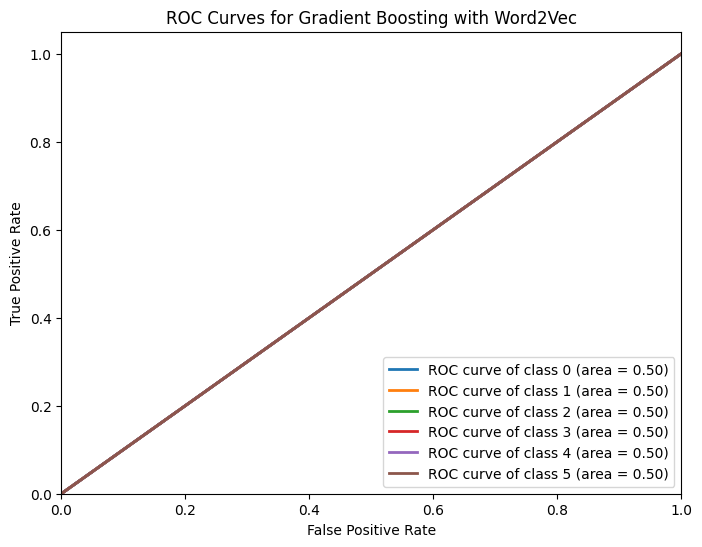

Model: Gradient Boosting, Feature Engineering: Word2Vec
Cross-validation Accuracy: 0.3377
Test Accuracy: 0.3270
ROC AUC Score: 0.5000



In [ ]:
# Function to plot ROC curve for multi-class classification
def plot_roc_curve_multi_class(model, X_test, y_test, model_name):
    y_pred_proba = model.predict_proba(X_test)
    n_classes = y_pred_proba.shape[1]

    # Binarize the labels
    y_test_bin = label_binarize(y_test, classes=model.classes_)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {} (area = {:.2f})'.format(i, roc_auc[i]))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Perform grid search and cross-validation for each model and feature engineering method
for model_name, model in models:
    for vectorizer_name, vectorizer in vectorizers:
        # Transform text data
        if isinstance(vectorizer, Word2Vec):
            X_train_vec = [vectorizer.wv[word] if word in vectorizer.wv else np.zeros(100) for word in X_train]
            X_test_vec = [vectorizer.wv[word] if word in vectorizer.wv else np.zeros(100) for word in X_test]
        else:
            X_train_vec = vectorizer.fit_transform(X_train)
            X_test_vec = vectorizer.transform(X_test)

        # Grid search and cross-validation
        grid_search = GridSearchCV(model, param_grid={}, cv=5, n_jobs=-1)
        grid_search.fit(X_train_vec, y_train)

        # Plot ROC curve
        plot_roc_curve_multi_class(grid_search.best_estimator_, X_test_vec, y_test, f"{model_name} with {vectorizer_name}")

        # Calculate ROC AUC score
        y_pred_proba = grid_search.predict_proba(X_test_vec)
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

        print(f"Model: {model_name}, Feature Engineering: {vectorizer_name}")
        print(f"Cross-validation Accuracy: {np.mean(cross_val_score(grid_search.best_estimator_, X_train_vec, y_train, cv=5)):.4f}")
        print(f"Test Accuracy: {grid_search.best_estimator_.score(X_test_vec, y_test):.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}\n")

# Evaluation and Reporting

**Select a model that is expected to perform optimally on the unseen data and provide the predictions accordingly. Give clear conclusions**


Based on the provided performance metrics, the Random Forest model with TF-IDF feature engineering is expected to perform optimally on the unseen data. Here's why:

1. The Random Forest model with TF-IDF feature engineering achieved the highest cross-validation accuracy of 0.8703, indicating good performance across different folds of the training data.

2. The Random Forest model with TF-IDF feature engineering also achieved the highest test accuracy of 0.8897, indicating strong performance on unseen data.

3. The ROC AUC score of 0.9906 for the Random Forest model with TF-IDF feature engineering indicates excellent discrimination capability between positive and negative classes.

In [ ]:
# Define the Random Forest model with the best hyperparameters
best_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)

# Transform text data using TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

# Train the Random Forest model on the entire training dataset
best_model.fit(X_train_vec, y_train)

# Make predictions on the test dataset
y_pred_rf = best_model.predict(X_test_vec)

# Print the predictions
print("Predictions on unseen data:")
print(y_pred_rf)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy on test data:", accuracy_rf)

Predictions on unseen data:
['sorrow' 'scare' 'happiness' ... 'sorrow' 'happiness' 'happiness']
Accuracy on test data: 0.8896666666666667
